In [18]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns



In [6]:
data = pd.read_csv('HDFCBANK.csv', parse_dates=['Date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

# Calculate the difference between the closing price of the first and last trading days for each year
data['Year'] = data['Date'].dt.year
yearly_changes = data.groupby('Year').agg({'Close': lambda x: x.iloc[-1] - x.iloc[0]})

C:\Users\Admin\AppData\Local\Temp\ipykernel_19804\661564874.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('HDFCBANK.csv', parse_dates=['Date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


In [22]:
data.describe()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Year
count,5306,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2456.000000,4.797000e+03,4797.000000,5306.000000
mean,2010-08-18 21:26:56.132679936,1007.093884,1007.472767,1019.986939,993.822211,1007.364003,1007.330390,1006.929263,2.102580e+06,2.448837e+14,82923.625407,1.261883e+06,0.595003,2010.137015
min,2000-01-03 00:00:00,157.400000,162.150000,167.900000,157.000000,163.000000,163.400000,161.400000,1.042000e+03,2.291142e+10,807.000000,4.631000e+03,0.177900,2000.000000
25%,2005-04-13 12:00:00,479.912500,482.112500,486.912500,473.100000,480.700000,480.200000,479.512500,3.058325e+05,1.640025e+13,26850.500000,2.624830e+05,0.517800,2005.000000
50%,2010-08-17 12:00:00,934.750000,939.350000,953.950000,922.175000,935.600000,935.725000,937.455000,9.444650e+05,1.150443e+14,44227.000000,6.271970e+05,0.600200,2010.000000
75%,2015-12-17 18:00:00,1421.000000,1423.525000,1440.000000,1399.000000,1422.812500,1421.000000,1420.567500,2.123647e+06,2.154477e+14,104139.250000,1.433151e+06,0.674000,2015.000000
max,2021-04-30 00:00:00,2565.800000,2566.000000,2583.300000,2553.700000,2563.000000,2565.800000,2570.700000,1.005650e+08,1.426400e+16,790631.000000,6.669683e+07,1.000000,2021.000000
std,NaN,635.757762,635.461516,641.444674,629.502818,635.722752,635.675021,635.481917,3.970048e+06,4.778103e+14,93575.061741,2.070127e+06,0.121337,6.163090


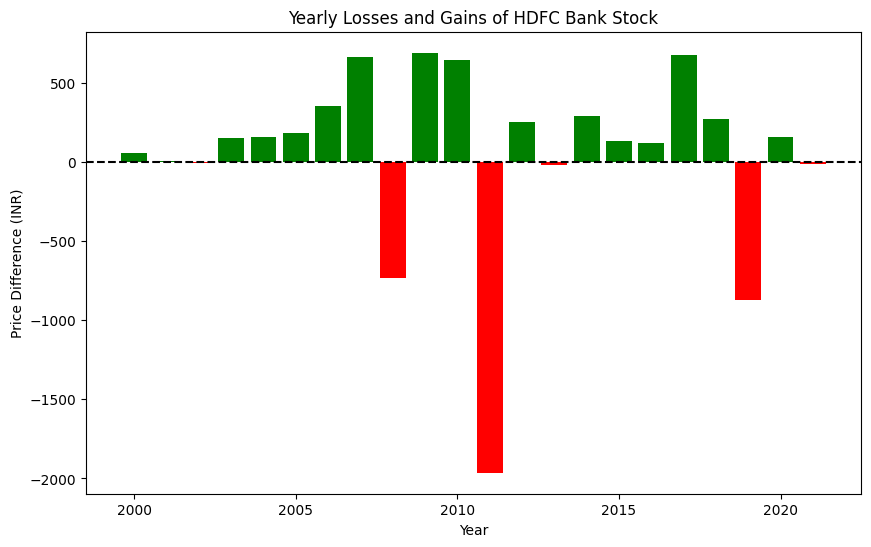

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(yearly_changes.index, yearly_changes['Close'], color=['red' if x < 0 else 'green' for x in yearly_changes['Close']])
plt.title('Yearly Losses and Gains of HDFC Bank Stock')
plt.xlabel('Year')
plt.ylabel('Price Difference (INR)')
plt.axhline(y=0, color='black', linestyle='--')  # Adding a horizontal line at y=0
plt.show()

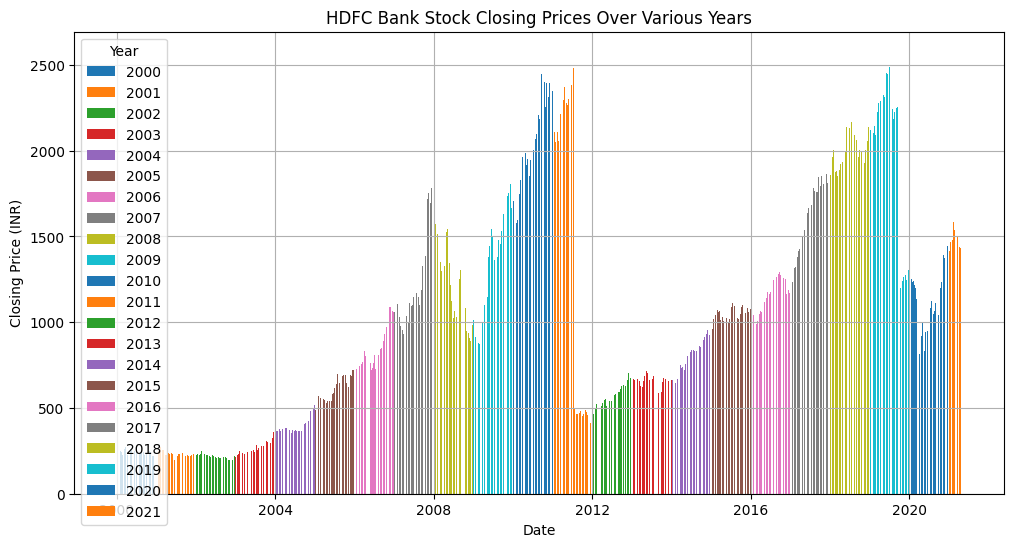

In [12]:
plt.figure(figsize=(12, 6))
for year in data['Year'].unique():
    plt.bar(data[data['Year'] == year]['Date'], data[data['Year'] == year]['Close'], label=year)

plt.title('HDFC Bank Stock Closing Prices Over Various Years')
plt.xlabel('Date')
plt.ylabel('Closing Price (INR)')
plt.legend(title='Year', loc='upper left')
plt.grid(True)
plt.show()

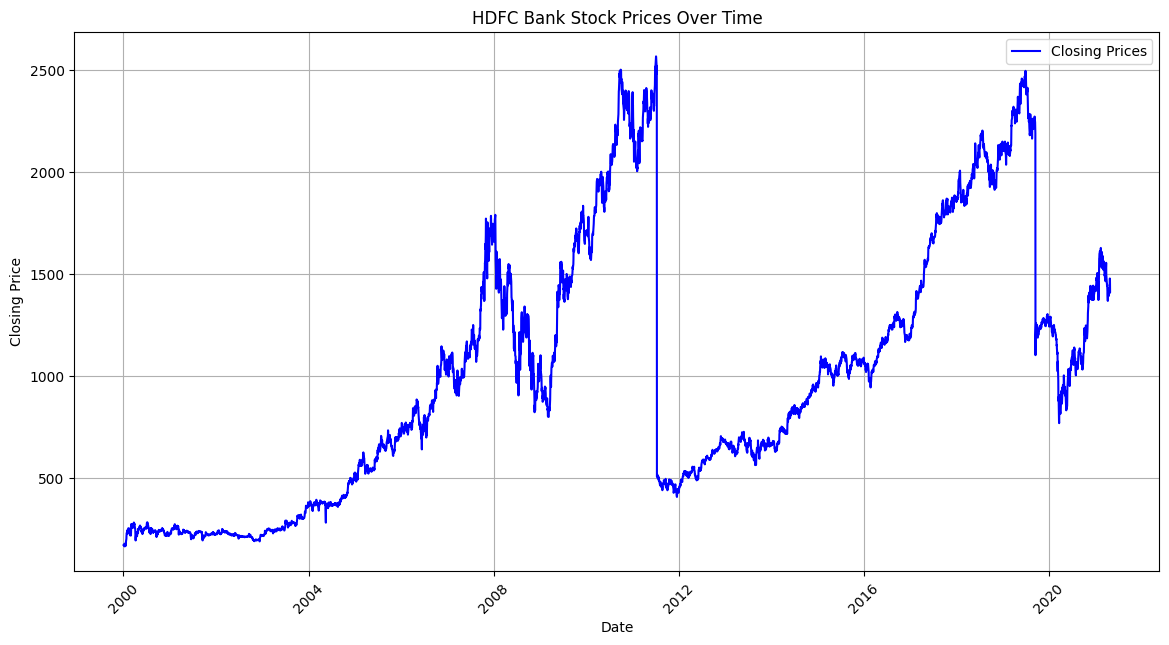

In [14]:
dates = pd.to_datetime(data['Date'])
closing_prices = data['Close']

# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(dates, closing_prices, color='b', label='Closing Prices')
plt.title('HDFC Bank Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

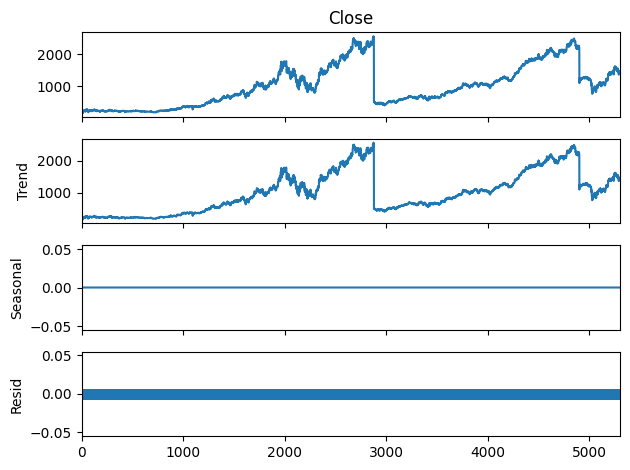

In [8]:
result = seasonal_decompose(data['Close'], model='additive', period=1)
result.plot()
plt.show()

In [9]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')

In [10]:
adf_test(data['Close'])

ADF Statistic: -2.295729291137966
p-value: 0.17334905995747613
Critical Values:
1%: -3.4315832642803406
5%: -2.8620849763501828
10%: -2.5670600903865166


In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Define and fit SARIMA model
model = SARIMAX(train['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_model = model.fit()

# Forecast future prices
forecast = fit_model.forecast(steps=len(test))

# Evaluate model performance
mae = mean_absolute_error(test['Close'], forecast)
mse = mean_squared_error(test['Close'], forecast)
rmse = np.sqrt(mse)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)


Mean Absolute Error: 479.17319105420734
Mean Squared Error: 310755.24079332955
Root Mean Squared Error: 557.4542499553928


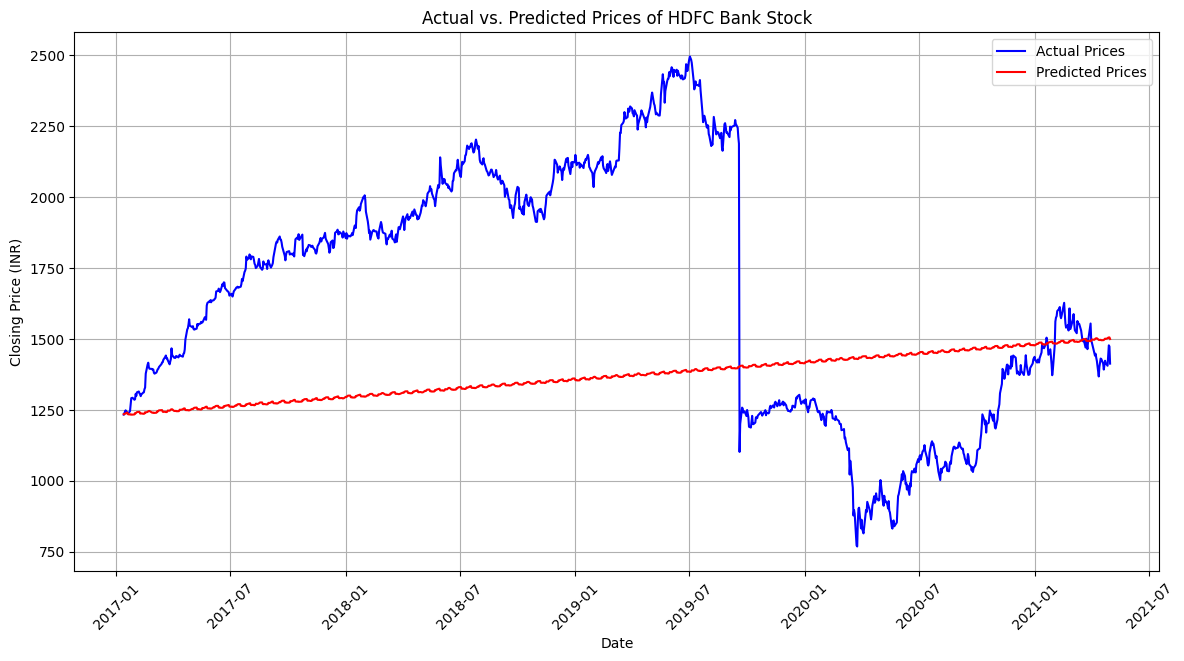

In [23]:
# Visualize actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(test['Date'], test['Close'], color='blue', label='Actual Prices')
plt.plot(test['Date'], forecast, color='red', label='Predicted Prices')
plt.title('Actual vs. Predicted Prices of HDFC Bank Stock')
plt.xlabel('Date')
plt.ylabel('Closing Price (INR)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()



In [45]:
from statsmodels.tsa.arima.model import ARIMA

# Define and fit ARIMA model
arima_model = ARIMA(train['Close'], order=(1, 1, 1))
arima_fit = arima_model.fit()

# Forecast future prices using ARIMA
arima_forecast = arima_fit.forecast(steps=len(test))

# Evaluate model performance
arima_mae = mean_absolute_error(test['Close'], arima_forecast)
arima_mse = mean_squared_error(test['Close'], arima_forecast)
arima_rmse = np.sqrt(arima_mse)

print('ARIMA Mean Absolute Error:', arima_mae)
print('ARIMA Mean Squared Error:', arima_mse)
print('ARIMA Root Mean Squared Error:', arima_rmse)



ARIMA Mean Absolute Error: 498.5845831710436
ARIMA Mean Squared Error: 375162.5307971079
ARIMA Root Mean Squared Error: 612.5051271598531


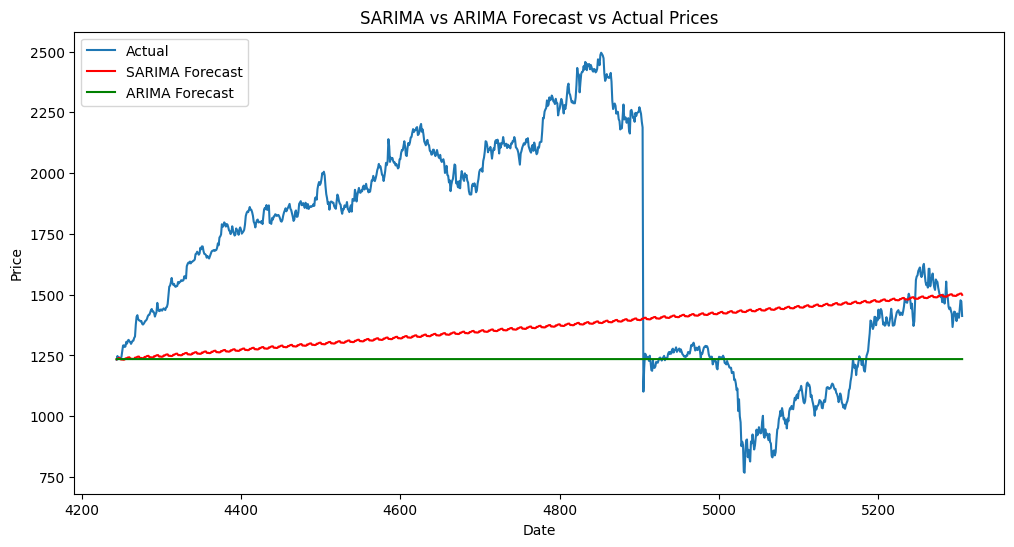

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, forecast, color='red', label='SARIMA Forecast')
plt.plot(test.index, arima_forecast, color='green', label='ARIMA Forecast')
plt.title('SARIMA vs ARIMA Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()